In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import subprocess
import time
import os

In [2]:
import re

def replacer(mod, num):
    # mod is 'cpp' or 'hs'
    num = str(num)
    with open(f'main.{mod}', encoding='utf8') as f_inp:
        data = f_inp.read()
    if mod == 'cpp' or mod == 'grf':
        data = re.sub(r'(?<=Is_prime\()\d+', num, data)
    elif mod == 'hs':
        data = re.sub(r'(?<=is_prime )\d+', num, data)
    with open(f'main.{mod}', 'w', encoding='utf8') as f_out:
        f_out.write(data)

In [3]:
def get_prime():
    num = 2
    while True:
        i = 2
        prime = True
        while i*i <= num:
            if num % i == 0:
                prime = False
                break
            i += 1
        if prime:
            yield num
        num += 1

In [98]:
# package_path = "/home/dmitry/IT/Sem7/GRF_emulator"

# def cpp_counter(numbers):
#     global df_dict
#     df_dict['cpp'] = []
#     df_dict['cpp+comp'] = []
#     for num in numbers:
#         replacer('cpp', num)
#         compilation_start = time.perf_counter()
#         subprocess.call("g++ -O2 -o main.out main.cpp".split())
#         exec_start = time.perf_counter()
#         cpp_comp_time = exec_start - compilation_start
#         subprocess.call("./main.out")
#         finish = time.perf_counter()
#         df_dict['cpp'].append(finish - exec_start)
#         df_dict['cpp+comp'].append(finish - exec_start + cpp_comp_time)


def haskell_counter(numbers, limit):
    global df_dict
    df_dict['hs'] = []
    df_dict['hs+comp'] = []
    flag_break = False
    for num in numbers:
        if flag_break:
            df_dict['hs'].append(None)
            df_dict['hs+comp'].append(None)
            continue
        replacer('hs', num)
        compilation_start = time.perf_counter()
        subprocess.call("ghc -o main.out main.hs".split())
        exec_start = time.perf_counter()
        hs_comp_time = exec_start - compilation_start
        subprocess.call("./main.out")
        finish = time.perf_counter()
        df_dict['hs'].append(finish - exec_start)
        df_dict['hs+comp'].append(finish - exec_start + hs_comp_time)
        if finish - exec_start + hs_comp_time > limit:
            flag_break = True


def python_counter(numbers, name, optimizations, limit):
    global df_dict
    df_dict[name] = []
    flags = " ".join(optimizations)
    flag_break = False
    for num in numbers:
        if flag_break:
            df_dict[name].append(None)
            continue
        replacer('grf', num)
        os.chdir('/home/dmitry/Sem7/GRF_emulator')
        exec_start = time.perf_counter()
        subprocess.call(f'python -m grfemulator.core {flags} experiments/main.grf'.split())
        finish = time.perf_counter()
        os.chdir('/home/dmitry/Sem7/GRF_emulator/experiments')
        df_dict[name].append(finish - exec_start)
        if finish - exec_start > limit:
            flag_break = True


def accurate_python_counter(numbers, name, optimizations, limit, accuracy):
    global df_dict
    for i in range(accuracy):
        python_counter(numbers, f'{name}{i}', optimizations, limit)
    df_dict[name] = [sum([df_dict[f'{name}{i}'][ind] for i in range(accuracy)]) / accuracy for ind in range(len(df_dict['number']))]
    for i in range(accuracy):
        del df_dict[f'{name}{i}']


df_dict = {'number': [i[0] for i in zip(get_prime(), range(50))]}
os.chdir('/home/dmitry/Sem7/GRF_emulator/experiments')

limit = 15
accuracy = 3
haskell_counter(df_dict['number'], limit)
# python_counter(df_dict['number'], 'python', [], limit)
python_counter(df_dict['number'], 'python_opt', ["--Orec-to-for"], limit)
python_counter(df_dict['number'], 'python_opportunistic', ["--Ougly-hack"], limit)

# accurate_python_counter(df_dict['number'], 'python_opportunistic', ["--Ougly-hack"], limit, accuracy)
# accurate_python_counter(df_dict['number'], 'python_opportunistic_opt', ["--Ougly-hack", "--Orec-to-for"], limit, accuracy)

[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2] Compiling Main             ( main.hs, main.o ) [Source file changed]
[2 of 2] Linking main.out [Objects changed]
1
[1 of 2]

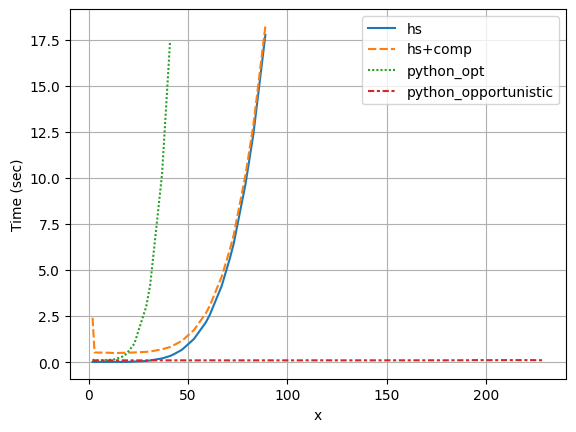

In [99]:
df = pd.DataFrame(df_dict).set_index('number')
sns.lineplot(data=df)
plt.xlabel('x')
plt.ylabel('Time (sec)')
plt.grid()

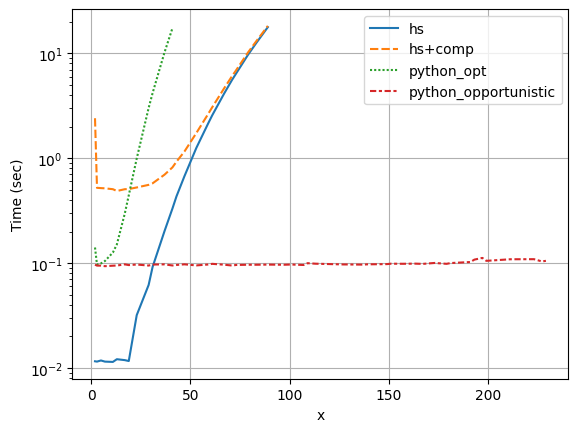

In [100]:
df = pd.DataFrame(df_dict).set_index('number')
sns.lineplot(data=df)
plt.xlabel('x')
plt.ylabel('Time (sec)')
plt.grid()
plt.yscale('log')

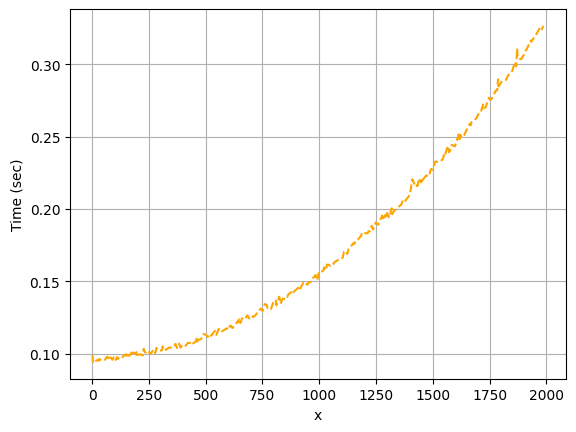

In [97]:
# df = pd.DataFrame(df_dict).set_index('number')
plt.plot(df_dict['number'], df_dict['python_opportunistic_opt'], '--', color='orange')
plt.xlabel('x')
plt.ylabel('Time (sec)')
plt.grid()